In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [2]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import threading
%matplotlib inline

In [3]:
def prepare_prediction(pred):
    mask = np.argmax(pred, axis=-1)
    mask = mask.astype('uint8')
    return mask

In [4]:
# overlay.load_model("tf2_.xmodel")
overlay.load_model("seneca4ctorg.xmodel")

In [5]:
image_folder = 'images'
original_images = [i for i in os.listdir(image_folder) if i.endswith("npy")]
total_images = len(original_images)
print(total_images)

2000


In [6]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

In [7]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

In [8]:
def run(image_index, save = False):
    preprocessed = np.load("images/" + original_images[image_index])
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    if save:
        pred = output_data[0]
        pred = prepare_prediction(pred)
        np.save('predictions/'+original_images[image_index], pred)

In [9]:
index = 9
run(index)

In [10]:
# output_data[0].shape
prediction = prepare_prediction(output_data[0])
# prediction.shape

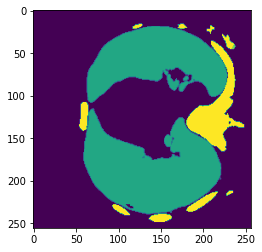

In [11]:
_, ax = plt.subplots(1)
_ = ax.imshow(prediction[0,:,:])

## Fino a qui :D

In [12]:
def single_thread(start, end):
    [run(i) for i in range(start, end)]

In [13]:
threads = 2

'''run threads '''
print('Starting',threads,'threads...')
threadAll = []
start=0
for i in range(threads):
    if (i==threads-1):
        end = len(original_images)
    else:
        end = start+(len(original_images)//threads)
    t1 = threading.Thread(target=single_thread, args=(start, end))
    threadAll.append(t1)
    #  print(start, end)
    start=end
    

time1 = time.time()
for x in threadAll:
    x.start()
for x in threadAll:
    x.join()
time2 = time.time()
timetotal = time2 - time1

fps = float(total_images / timetotal)
print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, total_images, timetotal))

Starting 2 threads...
Throughput=59.48 fps, total frames = 2000, time=33.6227 seconds


In [14]:
# Save output to evaluate performance
print("Saving predictions")
os.makedirs('predictions', exist_ok=True)

[run(i, save = True) for i in range(total_images)]


Saving predictions


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

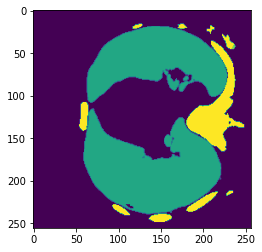

In [15]:
pred = np.load("predictions/" + original_images[index])
_, ax = plt.subplots(1)
_ = ax.imshow(prediction[0,:,:])